# Hello
Hi Stefaan, deine Mama ist ne Nutte. **Positiv gemeint!**

Mostly according to https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
import re

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## Helper Functions

In [3]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = train.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## Load Data

In [4]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
full = [train, test]

## Feature Analysis

In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Variable Description

- **Survived:** Survived (1) or died (0)
- **Pclass:** Passenger's class
- **Name:** Passenger's name
- **Sex:** Passenger's sex
- **Age:** Passenger's age
- **SibSp:** Number of siblings/spouses aboard
- **Parch:** Number of parents/children aboard
- **Ticket:** Ticket number
- **Fare:** Fare
- **Cabin:** Cabin
- **Embarked:** Port of embarkation


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Missing Data

In [7]:
print("Training Data \n")
print(train.isnull().sum()/train.shape[0]*100)
print("\n Test Data \n")
print(test.isnull().sum()/test.shape[0]*100)

Training Data 

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

 Test Data 

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


**This implies that `Cabin` is an inadequate feature.**

### Does Age Matter?

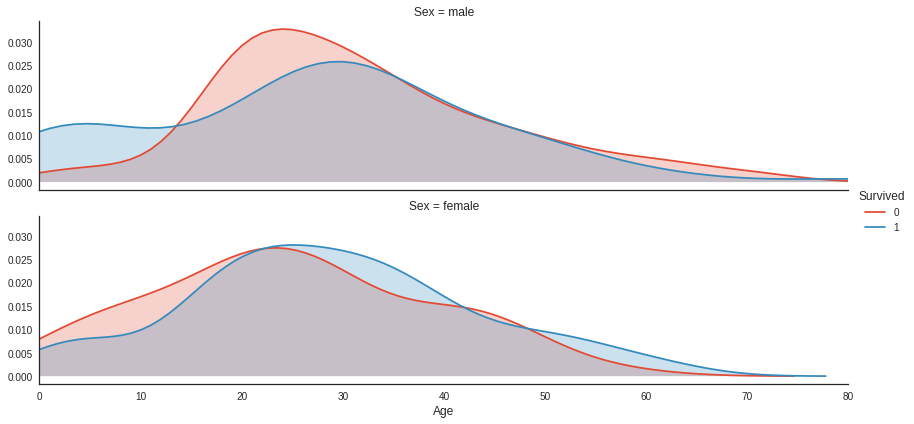

In [8]:
plot_distribution( train , var = 'Age' , target = 'Survived', row = 'Sex' )

**Observation:**
- Age does not seperate satisfactory

### Does Sex Matter?

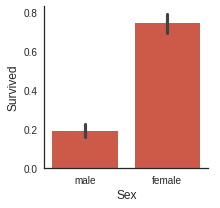

In [9]:
plot_categories( train , cat = 'Sex' , target = 'Survived' )

### Embarked

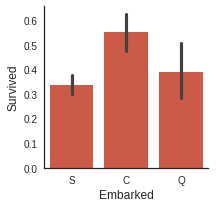

In [10]:
plot_categories( train , cat = 'Embarked' , target = 'Survived' )

**Observation:** Seems to be important

### Strip Names down to their Titles
Obviously the Name itself does not give us important information and is therefore not good feature for our learning machine.

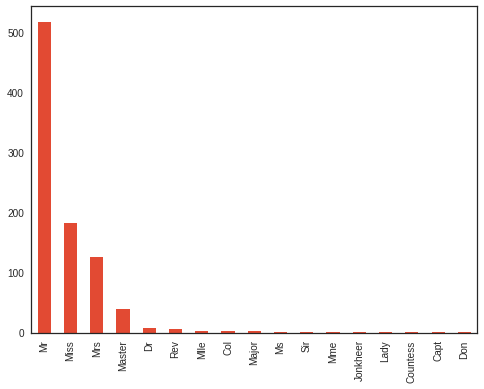

In [11]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full:
    dataset['Title'] = dataset['Name'].apply(get_title)

train['Title'].value_counts().plot(kind='bar')

Let's group the minorities together to a `Res` group:

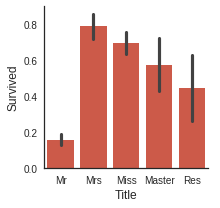

In [12]:
def group_titles(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        name = title_search.group(1)
        if name in ['Mr', 'Miss', 'Mrs', 'Master']:
            return name
        else:
            return 'Res'
    return ""

for dataset in full:
    dataset['Title'] = dataset['Name'].apply(group_titles)#
    
plot_categories( train , cat = 'Title' , target = 'Survived' )

### Does Money Matter?

fuuuu wie ging denn das nochmal

### Make All Variables Numeric

In [13]:
# src https://www.kaggle.com/headsortails/pytanic Chap 6.
try:
    for dataset in full:
        dataset['Sex'] = dataset['Sex'].replace( {'female': 1, 'male': 0})
        dataset['Embarked'] = dataset['Embarked'].replace( {'S': 0, 'Q': 1, 'C': 2})
except TypeError:
    # Just works the first time
    pass

### Correlation Map

First make all Values numeric


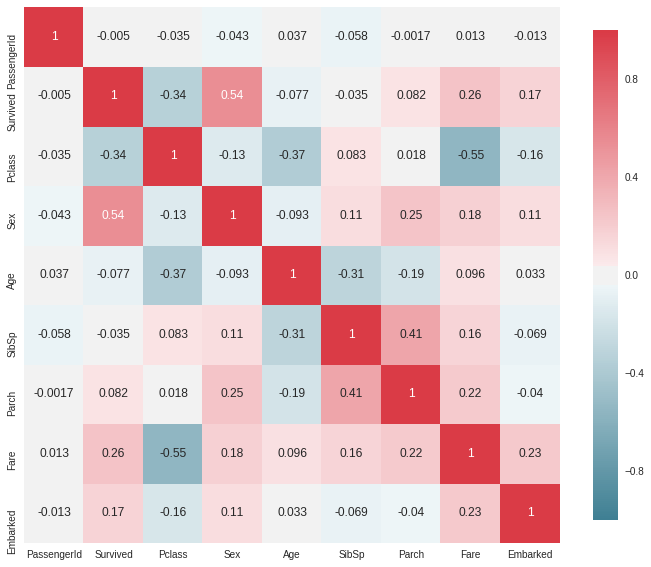

In [14]:
plot_correlation_map(train)

### Drop Data
Now we can drop data, that is not important for us.

In [15]:
train = train.drop(['SibSp', 'Ticket', 'Cabin', 'Title', 'Name'], axis=1)
test = test.drop(['SibSp', 'Ticket', 'Cabin', 'Title', 'Name'], axis=1)

In [17]:
test.head()

,PassengerId,Pclass,Sex,Age,Parch,Fare,Embarked
0,892,3,0,34.5,0,7.8292,1
1,893,3,1,47.0,0,7.0000,0
2,894,2,0,62.0,0,9.6875,1
3,895,3,0,27.0,0,8.6625,0
4,896,3,1,22.0,1,12.2875,0


In [24]:
# SOUNDS GOOD, DOESN'T WORK

#For fitting all the data
Xtrain = train[train.notnan()].drop('Survived', 1)
Ytrain = train[train.notnan()]['Survived']

gaussian = GaussianNB()
gaussian.fit(Xtrain, Ytrain)

AttributeError: 'DataFrame' object has no attribute 'notnan'